<a href="https://colab.research.google.com/github/DarinJoshua-dev/Deep-Learning-Text-Emotion-Analyzer/blob/master/Deep_Learning_Text_Emotion_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Text Emotion Analyzer**
Implementing the Deep Learning Recurrent Neural Network Algorithm by PyTorch and tools to identify the different emotions in the text and paragraphs i.e. training and predicting accurately the emotions of anger, fear, joy, surprise and sadness by using the model.

![RNN Model](https://hackernoon.com/hn-images/1*6xj691fPWf3S-mWUCbxSJg.jpeg)

In [ ]:
#Install PyTorch 
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl 

     |████████████████████████████████| 483.0MB 1.2MB/s 
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.61 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101


# **Eager Execution**
Eager execution allows us to operate on the computation graph dynamically, also known as imperative programming. TensorFlow requires that you manually set this mode, while PyTorch comes with this mode by default. Below we import the necessary libraries to use PyTorch.

In [ ]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# **Computational Graph**
![Computational Graph](https://algorithmia.com/blog/wp-content/uploads/2018/05/pytorch-3.jpg)

# **Math and Transformation of Tensors** 

In [ ]:
c = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
d = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
e = torch.matmul(c, d)
print(e)
print(c.size())

tensor([[1., 3.],
        [3., 7.]])
torch.Size([2, 2])


![Tensor](https://algorithmia.com/blog/wp-content/uploads/2018/05/pytorch-2.jpg)

In [ ]:
### Automatic differentiation with PyTorch
x = torch.ones(2, 2, requires_grad=True)

# an operation of tensor
y = x + 2 # y inherits grad_fn

# apply operations on y
z = y * y * 3
out = z.mean()

print(out)

out.backward()

print(x.grad) # d(out)/dx

tensor(27., grad_fn=<MeanBackward1>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [ ]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
print("X shape: ", x.size())

# add dimension
print(x.unsqueeze(1).size()) 

# transpose 
torch.transpose(x, 0,1)

X shape:  torch.Size([2, 3])
torch.Size([2, 1, 3])


tensor([[1, 4],
        [2, 5],
        [3, 6]])

# **Emotion Dataset**
An Emotion Dataset containing of tweets labelled into six categories is used in the model


In [ ]:
import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [ ]:
### Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

In [ ]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


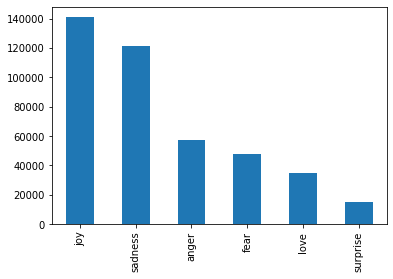

In [ ]:
# load data
data = load_from_pickle(directory="/gdrive/My Drive/Projects/Codes/Deep Learning Text Emotion Analyzer/emotion_text.pkl")
data.emotions.value_counts().plot.bar()

In [ ]:
data.head(10)

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
18231,i find myself frustrated with christians becau...,love
10714,i am one of those people who feels like going ...,joy
35177,i feel especially pleased about this as this h...,joy
122177,i was struggling with these awful feelings and...,joy
26723,i feel so enraged but helpless at the same time,anger


# **Preprocessing Data**

**1) Tokenization and Sampling**

In [ ]:
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling
data = data.sample(n=50000);

**2) Constructing Vocabulary and Index-Word Mapping**

In [ ]:
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [ ]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aa',
 'aaaaaaaall',
 'aaaaah',
 'aab',
 'aabsolutely',
 'aaliyah',
 'aaradhya',
 'aardvark',
 'aaron']

# **Converting Data into Tensors**

In [ ]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [ ]:
# examples of what is in the input tensors
input_tensor[0:4]

[[11761, 781, 8899, 15738, 13123, 504],
 [11761,
  27215,
  10858,
  1473,
  16517,
  18611,
  1473,
  17743,
  16426,
  14968,
  11579,
  23431,
  11761,
  8887,
  72,
  860,
  12769,
  2105,
  11761,
  13529,
  12774,
  14652,
  24459,
  8887,
  20207,
  899,
  13146,
  899,
  13879,
  24459,
  26630,
  24788,
  24082,
  24788,
  22575,
  7742],
 [11761,
  8887,
  16426,
  16180,
  24788,
  16784,
  12774,
  24562,
  11761,
  6995,
  8887,
  1,
  2440,
  23836,
  12036,
  24436,
  1215,
  16773,
  12737,
  21693,
  7034,
  24543,
  13203,
  24788,
  25269,
  899,
  14479,
  694,
  24436,
  17743,
  26942,
  10963,
  2824,
  24788,
  1225,
  4538,
  27104,
  11162,
  12036,
  27104,
  24436,
  27161,
  10947,
  15505],
 [11761,
  8887,
  7928,
  6438,
  9344,
  899,
  19586,
  9411,
  24436,
  9060,
  26780,
  16773,
  27215,
  899,
  27228,
  12036]]

# **Padding of data**

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

68


In [ ]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [ ]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [ ]:
input_tensor[0:4]

[array([11761,   781,  8899, 15738, 13123,   504,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]),
 array([11761, 27215, 10858,  1473, 16517, 18611,  1473, 17743, 16426,
        14968, 11579, 23431, 11761,  8887,    72,   860, 12769,  2105,
        11761, 13529, 12774, 14652, 24459,  8887, 20207,   899, 13146,
          899, 13879, 24459, 26630, 24788, 24082, 24788, 22575,  7742,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    

# **Binarization**

In [ ]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [ ]:
target_tensor[0:4] 

array([[0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [ ]:
data[0:4]

,text,emotions,token_size
6722,i am feeling more joyful again,joy,6
50713,i work hard at not preaching at people no matt...,anger,36
17473,i feel no need to offer it though i do feel a ...,fear,44
35005,i feel energetic determined focused and ready ...,joy,16


In [ ]:
get_emotion = lambda t: np.argmax(t)

In [ ]:
get_emotion(target_tensor[0])

2

In [ ]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [ ]:
emotion_dict[get_emotion(target_tensor[3])]

'joy'

# **Spliting data**

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

# **Data Loader and Batch Processing**

In [ ]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [ ]:
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [ ]:
val_dataset.batch_size

64

# **Model**

**1) Constructing the Model**

In [ ]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

**2)  Pretesting the model**

In [ ]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataset)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print(output.size())

Input size:  torch.Size([68, 64])
torch.Size([64, 6])


# **Training the Model**

In [ ]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1 ,0).to(device), lens, device) # TODO:don't need _   
              
        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
            
    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):        
        predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.3045
Epoch 1 Batch 100 Val. Loss 0.2847
Epoch 1 Batch 200 Val. Loss 0.1997
Epoch 1 Batch 300 Val. Loss 0.0757
Epoch 1 Batch 400 Val. Loss 0.0338
Epoch 1 Batch 500 Val. Loss 0.0205
Epoch 1 Batch 600 Val. Loss 0.0450
Epoch 1 Loss 0.1401 -- Train Acc. 67.0000 -- Val Acc. 90.0000
Time taken for 1 epoch 60.36439299583435 sec

Epoch 2 Batch 0 Val. Loss 0.0306
Epoch 2 Batch 100 Val. Loss 0.0412
Epoch 2 Batch 200 Val. Loss 0.0385
Epoch 2 Batch 300 Val. Loss 0.0247
Epoch 2 Batch 400 Val. Loss 0.0147
Epoch 2 Batch 500 Val. Loss 0.0211
Epoch 2 Batch 600 Val. Loss 0.0294
Epoch 2 Loss 0.0264 -- Train Acc. 92.0000 -- Val Acc. 91.0000
Time taken for 1 epoch 60.306763648986816 sec

Epoch 3 Batch 0 Val. Loss 0.0157
Epoch 3 Batch 100 Val. Loss 0.0210
Epoch 3 Batch 200 Val. Loss 0.0159
Epoch 3 Batch 300 Val. Loss 0.0218
Epoch 3 Batch 400 Val. Loss 0.0149
Epoch 3 Batch 500 Val. Loss 0.0102
Epoch 3 Batch 600 Val. Loss 0.0303
Epoch 3 Loss 0.0201 -- Train Acc. 93.0000 -- Val Acc. 

In [ ]:
model.parameters

<bound method Module.parameters of EmoGRU(
  (embedding): Embedding(27613, 256)
  (dropout): Dropout(p=0.5)
  (gru): GRU(256, 1024)
  (fc): Linear(in_features=1024, out_features=6, bias=True)
)>

# **Assessment of the Testing Data**

In [ ]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cuda" # we don't need GPU to do testing
model.to("cuda")

for (batch, (inp, targ, lens)) in enumerate(test_dataset):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)

Test Accuracy:  91.6923076923077


# **Confusion Matrix**
A confusion matrix is a table that is often used to describe the performance of a ML/DL model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

In [ ]:
### Class to Properly Evaluate our Models
class Evaluate():

    def va_dist(cls, prediction, target, va_df, binarizer, name='', silent=False):
        """ Computes distance between actual and prediction through cosine distance """
        va_matrix = va_df.loc[binarizer.classes_][['valence','arousal']].values
        y_va = target.dot(va_matrix)
        F_va = prediction.dot(va_matrix)

        # dist is a one row vector with size of the test data passed(emotion)
        dist = metrics.pairwise.paired_cosine_distances(y_va, F_va)
        res = stats.describe(dist)

        # print by default (if silent=False)
        if not silent:
            print('%s\tmean: %f\tvariance: %f' % (name, res.mean, res.variance))

        return {
            'distances': dist,
            'dist_stat': res
        }

    def evaluate_class(cls, predictions, target, target2=None, silent=False):
        """ Compute only the predicted class """
        p_2_annotation = dict()

        precision_recall_fscore_support = [
            (pair[0], pair[1].mean()) for pair in zip(
                ['precision', 'recall', 'f1', 'support'],
                metrics.precision_recall_fscore_support(target, predictions)
            )
        ]

        metrics.precision_recall_fscore_support(target, predictions)

        # confusion matrix
        le = LabelEncoder()
        target_le = le.fit_transform(target)
        predictions_le = le.transform(predictions)
        cm = metrics.confusion_matrix(target_le, predictions_le)

        # prediction if two annotations are given on test data
        if target2:
            p_2_annotation = pd.DataFrame(
                [(pred, pred in set([t1,t2])) for pred, t1, t2 in zip(predictions, target, target2)],
                columns=['emo','success']
            ).groupby('emo').apply(lambda emo: emo.success.sum()/ len(emo.success)).to_dict()

        if not silent:
            print("Default Classification report")
            print(metrics.classification_report(target, predictions))

            # print if target2 was provided
            if len(p_2_annotation) > 0:
                print('\nPrecision on 2 annotations:')
                for emo in p_2_annotation:
                    print("%s: %.2f" % (emo, p_2_annotation[emo]))

            # print accuracies, precision, recall, and f1
            print('\nAccuracy:')
            print(metrics.accuracy_score(target, predictions))
            print("Correct Predictions: ", metrics.accuracy_score(target, predictions,normalize=False))
            for to_print in precision_recall_fscore_support[:3]:
                print( "%s: %.2f" % to_print )

            # normalizing the values of the consfusion matrix
            print('\nconfusion matrix\n %s' % cm)
            print('(row=expected, col=predicted)')
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cls.plot_confusion_matrix(cm_normalized, le.classes_, 'Confusion matrix Normalized')

        return {
            'precision_recall_fscore_support': precision_recall_fscore_support,
            'accuracy': metrics.accuracy_score(target, predictions),
            'p_2_annotation': p_2_annotation,
            'confusion_matrix': cm
        }

    def predict_class(cls, X_train, y_train, X_test, y_test,
                      pipeline, silent=False, target2=None):
        """ Predicted class,then run some performance evaluation """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)
        print("predictions computed....")
        return cls.evaluate_class(predictions, y_test, target2, silent)

    def evaluate_prob(cls, prediction, target_rank, target_class, binarizer, va_df, silent=False, target2=None):
        """ Evaluate through probability """
        # Run normal class evaluator
        predict_class = binarizer.classes_[prediction.argmax(axis=1)]
        class_eval = cls.evaluate_class(predict_class, target_class, target2, silent)

        if not silent:
            print('\n - First Emotion Classification Metrics -')
            print('\n - Multiple Emotion rank Metrics -')
            print('VA Cosine Distance')

        classes_dist = [
            (
                emo,
                cls.va_dist(
                    prediction[np.array(target_class) == emo],
                    target_rank[np.array(target_class) == emo],
                    va_df,
                    binarizer,
                    emo,
                    silent)
                ) for emo in binarizer.classes_
        ]
        avg_dist = cls.va_dist(prediction, target_rank, va_df, binarizer, 'avg', silent)

        coverage_error = metrics.coverage_error(target_rank, prediction)
        average_precision_score = metrics.average_precision_score(target_rank, prediction)
        label_ranking_average_precision_score = metrics.label_ranking_average_precision_score(target_rank, prediction)
        label_ranking_loss = metrics.label_ranking_loss(target_rank, prediction)

        # recall at 2
        # obtain top two predictions
        top2_pred = [set([binarizer.classes_[i[0]], binarizer.classes_[i[1]]]) for i in (prediction.argsort(axis=1).T[-2:].T)]
        recall_at_2 = pd.DataFrame(
            [
            t in p for t, p in zip(target_class, top2_pred)
            ], index=target_class, columns=['recall@2']).groupby(level=0).apply(lambda emo: emo.sum()/len(emo))

        # combine target into sets
        if target2:
            union_target = [set(t) for t in zip(target_class, target2)]
        else:
            union_target = [set(t) for t in zip(target_class)]

        # precision at k
        top_k_pred = [
            [set([binarizer.classes_[i] for i in i_list]) for i_list in (prediction.argsort(axis=1).T[-i:].T)]
            for i in range(2, len(binarizer.classes_)+1)]
        precision_at_k = [
            ('p@' + str(k+2), np.array([len(t & p)/(k+2) for t, p in zip(union_target, top_k_pred[k])]).mean())
            for k in range(len(top_k_pred))]

        # do this if silent= False
        if not silent:
            print('\n')
            print(recall_at_2)
            print('\n')
            print('p@k')
            for pk in precision_at_k:
                print(pk[0] + ':\t' + str(pk[1]))
            print('\ncoverage_error: %f' % coverage_error)
            print('average_precision_score: %f' % average_precision_score)
            print('label_ranking_average_precision_score: %f' % label_ranking_average_precision_score)
            print('label_ranking_loss: %f' % label_ranking_loss)

        return {
            'class_eval': class_eval,
            'recall_at_2': recall_at_2.to_dict(),
            'precision_at_2': precision_at_k,
            'classes_dist': classes_dist,
            'avg_dist': avg_dist,
            'coverage_error': coverage_error,
            'average_precision_score': average_precision_score,
            'label_ranking_average_precision_score': label_ranking_average_precision_score,
            'label_ranking_loss': label_ranking_loss
        }


    def predict_prob(cls, X_train, y_train, X_test, y_test, label_test, pipeline, binarizer, va_df, silent=False, target2=None):
        """ Output predcations based on training and labels """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict_proba(X_test)
        pred_to_mlb = [np.where(pipeline.classes_ == emo)[0][0] for emo in binarizer.classes_.tolist()]
        return cls.evaluate_prob(predictions[:,pred_to_mlb], y_test, label_test, binarizer, va_df, silent, target2)


    def plot_confusion_matrix(cls, cm, my_tags, title='Confusion matrix', cmap=plt.cm.Blues):
        """ Plotting the confusion_matrix"""
        plt.rc('figure', figsize=(4, 4), dpi=100)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(my_tags))
        target_names = my_tags
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
        # add normalized values inside the Confusion matrix
        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Default Classification report
              precision    recall  f1-score   support

       anger       0.91      0.94      0.92       703
        fear       0.90      0.87      0.89       543
         joy       0.95      0.93      0.94      1742
        love       0.76      0.83      0.79       398
     sadness       0.97      0.96      0.96      1436
    surprise       0.80      0.82      0.81       170

    accuracy                           0.92      4992
   macro avg       0.88      0.89      0.89      4992
weighted avg       0.92      0.92      0.92      4992


Accuracy:
0.9216746794871795
Correct Predictions:  4601
precision: 0.88
recall: 0.89
f1: 0.89

confusion matrix
 [[ 662   13    6    5   17    0]
 [  27  474    1    0   20   21]
 [   7    2 1620   96    5   12]
 [   0    0   67  331    0    0]
 [  33   16    7    3 1375    2]
 [   0   21    9    1    0  139]]
(row=expected, col=predicted)


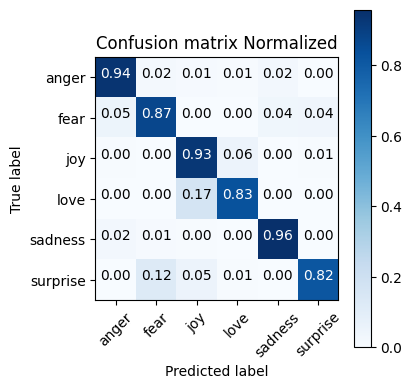

In [ ]:
evaluator = Evaluate()

final_predictions = []

for p in all_predictions:
    for sub_p in p:
        final_predictions.append(sub_p.cpu().detach().numpy())
        
predictions = [np.argmax(p).item() for p in final_predictions]
targets = [np.argmax(t).item() for t in y_raw]
correct_predictions = float(np.sum(predictions == targets))

# predictions
predictions_human_readable = ((x_raw, predictions))
# actual targets
target_human_readable = ((x_raw,  targets))

emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: emotion_dict[int(x)])

evaluator.evaluate_class(model_test_result.emotion, test.emotion );

# **Conclusion**
Trained the Deep Learning model to predict accurately; the emotions of anger, fear, joy, surprise and sadness  by the pickled Emotion-Text Dataset using Analysis & RNN model implemented by PyTorch and other tools and packages to evaluate above 91% accuracy in test. Also by implmenting the Confusion Matrix and Test Asssessment.

# **References**



*  [ Python Documentation](https://docs.python.org/3/)

*   [Artificial Intelligence Implementations](https://www.programmableweb.com/category/artificial-intelligence/source-code)

*   [Deep Learning Framework PyTorch](https://algorithmia.com/blog/exploring-the-deep-learning-framework-pytorch)

*   [Deep Learning Basics ](https://colab.research.google.com/github/lexfridman/mit-deep-learning/blob/master/tutorial_deep_learning_basics/deep_learning_basics.ipynb)

*   [Recurrent Neural Basics](https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV)

*   [Deep Learning Models by Pytorch](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/)

*   [Text Processing Implementations](https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing)

*   [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)

*  [ Other Packages Documentation Source](https://https://pypi.org/)

*   [RNN Model by Deep Learning](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470)

*   [Google AI HUB](https://aihub.cloud.google.com/u/0/s?category=notebook)

*   [Text Classification with Python](https://realpython.com/python-keras-text-classification/)

*   [Confusion Matrix Visualization](https://colab.research.google.com/drive/1ISfhxFDntfOos7cOeT7swduSqzLEqyFn)

